In [47]:
import torch
import torch.nn as nn
import torchvision
from dataset import CustomImageSet
from plots import display_n_images, plot_confusion_matrix
from sklearn.metrics import classification_report
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchinfo import summary
from torchvision import models, transforms
from tqdm import tqdm

In [2]:
print(f"CUDA available: {torch.cuda.is_available()}")
cuda = torch.device("cuda")

CUDA available: True


In [3]:
train_path = "C:/Users/voicu/OneDrive/Desktop/licenta/OCT2017/train"
validation_path = "C:/Users/voicu/OneDrive/Desktop/licenta/OCT2017/val"
test_path = "C:/Users/voicu/OneDrive/Desktop/licenta/OCT2017/test"

In [4]:
weights = models.VGG16_Weights.IMAGENET1K_V1
auto_transforms = weights.transforms()
print(auto_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [5]:
vgg16_transforms = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

simple_transform = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])
sS
data_augmentation_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

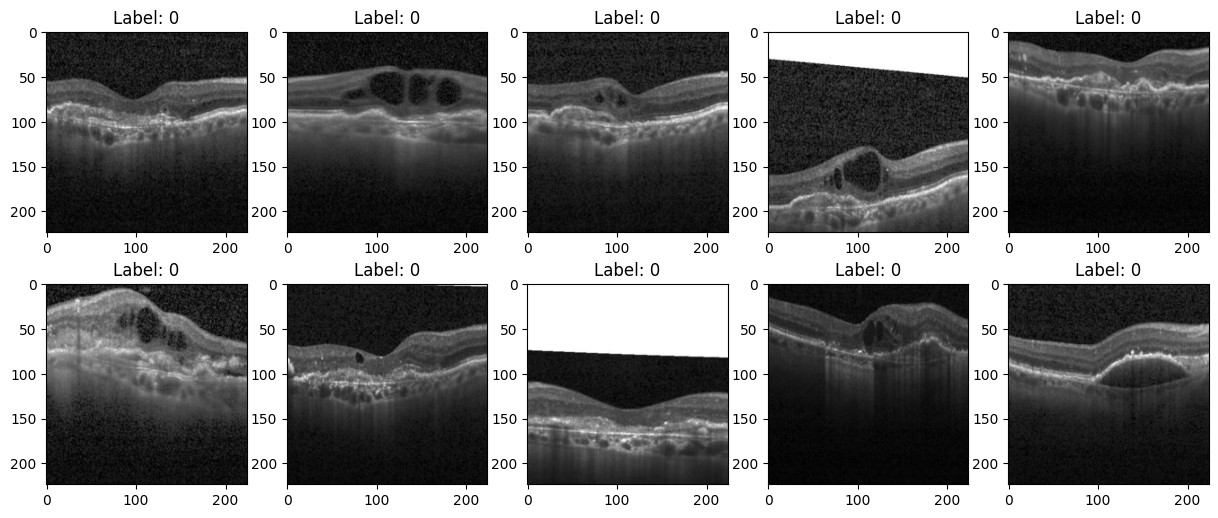

In [6]:
# display data without normalization
dataset = CustomImageSet(test_path, 10, simple_transform)
display_n_images(10, dataset)

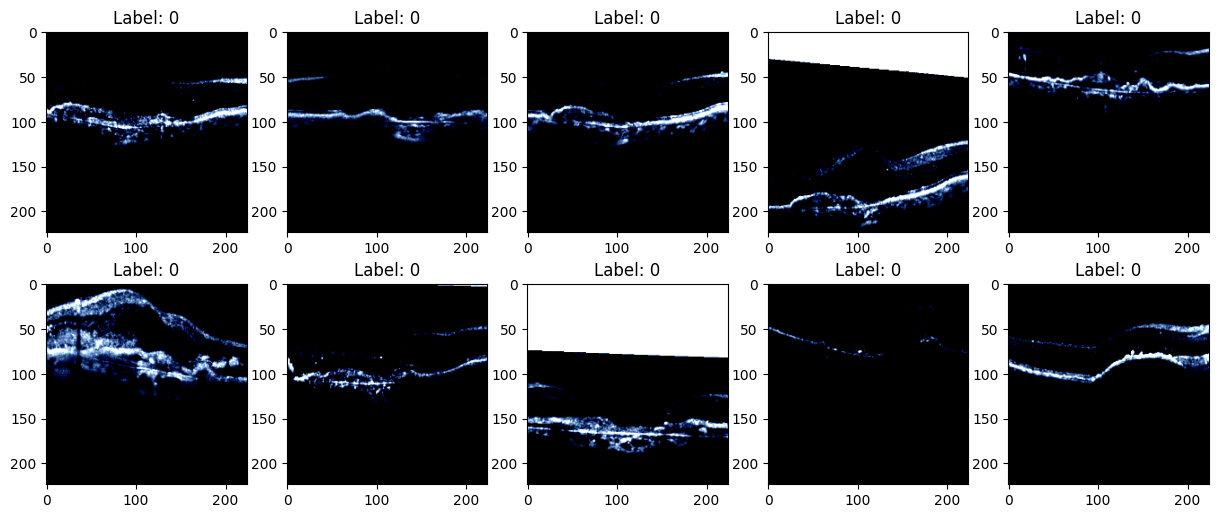

In [7]:
# display data after normalization
dataset = CustomImageSet(test_path, 10, vgg16_transforms)
display_n_images(10, dataset)

In [10]:
vgg16 = torchvision.models.vgg16(pretrained=True).to(cuda)

C:\Users\voicu\PycharmProjects\license\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\voicu\PycharmProjects\license\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
def summary_of_model(model, input_size):
    print(summary(model=model,
                  input_size=input_size,
                  col_names=["input_size", "output_size", "num_params", "trainable"],
                  col_width=20,
                  row_settings=["var_names"])
          )

In [12]:
summary_of_model(vgg16, (32, 3, 224, 224))

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VGG (VGG)                                [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                  [32, 3, 224, 224]    [32, 512, 7, 7]      --                   True
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 224, 224]   1,792                True
│    └─ReLU (1)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─Conv2d (2)                        [32, 64, 224, 224]   [32, 64, 224, 224]   36,928               True
│    └─ReLU (3)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─MaxPool2d (4)                     [32, 64, 224, 224]   [32, 64, 112, 112]   --                   --
│    └─Conv2d (5)                        [32, 64, 112, 112]   [32, 128, 112, 112]  73,856               True
│    └─ReLU (6)     

C:\Users\voicu\PycharmProjects\license\venv\Lib\site-packages\torchinfo\torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),


In [13]:
for param in vgg16.parameters():
    param.requires_grad = False

In [14]:
num_filters = vgg16.classifier[-1].in_features
# define a new layer
vgg16.classifier[-1] = nn.Linear(4096, 4)

In [15]:
summary_of_model(vgg16, (32, 3, 224, 224))

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VGG (VGG)                                [32, 3, 224, 224]    [32, 4]              --                   Partial
├─Sequential (features)                  [32, 3, 224, 224]    [32, 512, 7, 7]      --                   False
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 224, 224]   (1,792)              False
│    └─ReLU (1)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─Conv2d (2)                        [32, 64, 224, 224]   [32, 64, 224, 224]   (36,928)             False
│    └─ReLU (3)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─MaxPool2d (4)                     [32, 64, 224, 224]   [32, 64, 112, 112]   --                   --
│    └─Conv2d (5)                        [32, 64, 112, 112]   [32, 128, 112, 112]  (73,856)             False
│    └─ReLU (

In [16]:
data_transforms = {
    'train': data_augmentation_transforms,
    'val': data_augmentation_transforms,
    'test': data_augmentation_transforms
}

In [17]:
train_dataset = CustomImageSet(train_path, 8500, transform=data_transforms['train'])
validation_dataset = CustomImageSet(validation_path, transform=data_transforms['val'])

In [18]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(validation_dataset, shuffle=True)

In [19]:
dataloaders = {
    'train': train_dataloader,
    'val': val_dataloader
}

In [20]:
data_sizes = {
    'train': len(train_dataset),
    'val': len(validation_dataset)
}

In [21]:
# loss function for categories
loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(vgg16.classifier.parameters())
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [22]:
def train_model(model, number_of_epochs, loss_function, optimizer, scheduler):
    best_acc = 0.0

    for epoch in range(number_of_epochs):
        print(f'Epoch {epoch}:')

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            loss = 0.0
            corrects = 0

            dataloader = dataloaders[phase]
            with tqdm(total=len(dataloader), desc=f'{phase} Epoch {epoch}', unit='batch') as pbar:
                for images, labels in dataloader:
                    images = images.to(cuda)
                    labels = labels.to(cuda)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(images)
                        _, predictions = torch.max(outputs, 1)
                        loss = loss_function(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    loss += loss.item() * images.size(0)
                    corrects += torch.sum(predictions == labels.data)

                    pbar.update(1)

            if phase == 'train':
                scheduler.step()

            epoch_loss = loss / data_sizes[phase]
            epoch_acc = corrects.double() / data_sizes[phase]

            print(f'Epoch {epoch}: loss = {epoch_loss:.4f}, accuracy = {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc

In [23]:
model = train_model(vgg16, 3, loss_function, optimizer, exp_lr_scheduler)

Epoch 0:


train Epoch 0: 100%|██████████| 1021/1021 [09:48<00:00,  1.73batch/s]


Epoch 0: loss = 0.0002, accuracy = 0.6641


val Epoch 0: 100%|██████████| 3400/3400 [05:05<00:00, 11.14batch/s]


Epoch 0: loss = 0.0013, accuracy = 0.7353
Epoch 1:


train Epoch 1: 100%|██████████| 1021/1021 [09:53<00:00,  1.72batch/s]


Epoch 1: loss = 0.0004, accuracy = 0.6872


val Epoch 1: 100%|██████████| 3400/3400 [01:26<00:00, 39.18batch/s]


Epoch 1: loss = 0.0004, accuracy = 0.7485
Epoch 2:


train Epoch 2: 100%|██████████| 1021/1021 [07:22<00:00,  2.31batch/s]


Epoch 2: loss = 0.0002, accuracy = 0.6879


val Epoch 2: 100%|██████████| 3400/3400 [01:03<00:00, 53.95batch/s]

Epoch 2: loss = 0.0009, accuracy = 0.7550


In [24]:
torch.save(vgg16.state_dict(), "models/vgg16.pth")

In [25]:
test_dataset = CustomImageSet(test_path, transform=data_transforms['test'])
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [26]:
true_labels = []
predicted_labels = []

In [27]:
with torch.no_grad():
    loss = 0.0
    corrects = 0
    total_samples = 0

    for images, labels in test_dataloader:
        images = images.to(cuda)
        labels = labels.to(cuda)

        outputs = vgg16(images)
        _, predictions = torch.max(outputs, 1)
        loss = loss_function(outputs, labels)

        loss += loss.item() * images.size(0)
        corrects += torch.sum(predictions == labels.data)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predictions.cpu().numpy())

test_accuracy = corrects / len(test_dataset)
test_loss = loss / len(test_dataset)

print(f'Test accuracy: {test_accuracy:.4f}')
print(f'Test loss: {test_loss:.4f}')

Test accuracy: 0.7838
Test loss: 0.0014


In [28]:
classification_rep = classification_report(true_labels, predicted_labels)
print('Classification Report:')
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.71      0.78       850
           1       0.78      0.83      0.80       850
           2       0.77      0.70      0.73       850
           3       0.75      0.89      0.82       850

    accuracy                           0.78      3400
   macro avg       0.79      0.78      0.78      3400
weighted avg       0.79      0.78      0.78      3400



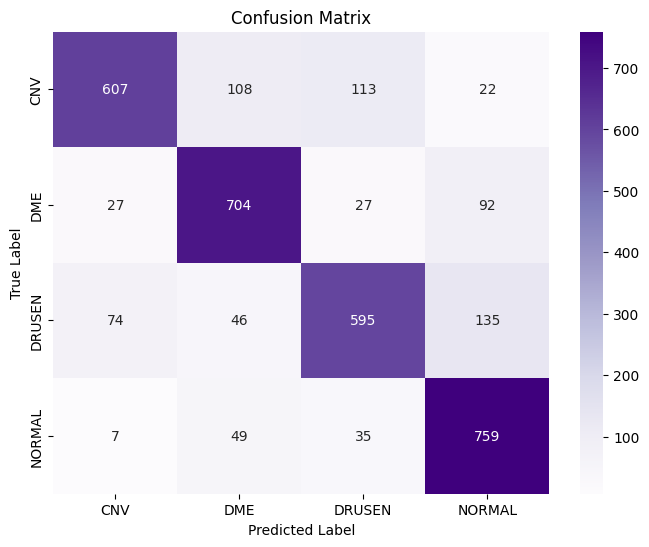

In [29]:
plot_confusion_matrix(true_labels, predicted_labels)

In [30]:
def flatten_model(model):
    layers = []
    for layer in model.children():
        if list(layer.children()):  # if the layer has children layers
            layers.extend(flatten_model(layer))
        else:
            layers.append(layer)
    return layers

In [31]:
all_layers = flatten_model(vgg16)
print("Number of layers in the base model:", len(all_layers))

Number of layers in the base model: 39


Fine-tuning the model

In [32]:
for param in vgg16.parameters():
    param.requires_grad = False

In [33]:
summary_of_model(vgg16, (32, 3, 224, 224))

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VGG (VGG)                                [32, 3, 224, 224]    [32, 4]              --                   False
├─Sequential (features)                  [32, 3, 224, 224]    [32, 512, 7, 7]      --                   False
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 224, 224]   (1,792)              False
│    └─ReLU (1)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─Conv2d (2)                        [32, 64, 224, 224]   [32, 64, 224, 224]   (36,928)             False
│    └─ReLU (3)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─MaxPool2d (4)                     [32, 64, 224, 224]   [32, 64, 112, 112]   --                   --
│    └─Conv2d (5)                        [32, 64, 112, 112]   [32, 128, 112, 112]  (73,856)             False
│    └─ReLU (6)

In [34]:
# unfreeze last 8 layers
for param in vgg16.features[-8:].parameters():
    param.requires_grad = True

for param in vgg16.classifier[-1].parameters():
    param.requires_grad = True

In [35]:
summary_of_model(vgg16, (32, 3, 224, 224))

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VGG (VGG)                                [32, 3, 224, 224]    [32, 4]              --                   Partial
├─Sequential (features)                  [32, 3, 224, 224]    [32, 512, 7, 7]      --                   Partial
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 224, 224]   (1,792)              False
│    └─ReLU (1)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─Conv2d (2)                        [32, 64, 224, 224]   [32, 64, 224, 224]   (36,928)             False
│    └─ReLU (3)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─MaxPool2d (4)                     [32, 64, 224, 224]   [32, 64, 112, 112]   --                   --
│    └─Conv2d (5)                        [32, 64, 112, 112]   [32, 128, 112, 112]  (73,856)             False
│    └─ReLU

In [36]:
optimizer = torch.optim.Adam(vgg16.parameters(), lr=1e-4)

In [37]:
model = train_model(vgg16, 3, loss_function, optimizer, exp_lr_scheduler)

Epoch 0:


train Epoch 0: 100%|██████████| 1021/1021 [11:18<00:00,  1.51batch/s]


Epoch 0: loss = 0.0002, accuracy = 0.8926


val Epoch 0: 100%|██████████| 3400/3400 [01:34<00:00, 35.98batch/s]


Epoch 0: loss = 0.0000, accuracy = 0.9112
Epoch 1:


train Epoch 1: 100%|██████████| 1021/1021 [07:24<00:00,  2.30batch/s]


Epoch 1: loss = 0.0001, accuracy = 0.9331


val Epoch 1: 100%|██████████| 3400/3400 [01:04<00:00, 52.56batch/s]


Epoch 1: loss = 0.0000, accuracy = 0.9265
Epoch 2:


train Epoch 2: 100%|██████████| 1021/1021 [07:15<00:00,  2.35batch/s]


Epoch 2: loss = 0.0003, accuracy = 0.9439


val Epoch 2: 100%|██████████| 3400/3400 [01:01<00:00, 54.96batch/s]

Epoch 2: loss = 0.0002, accuracy = 0.9118


In [38]:
torch.save(vgg16.state_dict(), "models/vgg16_fine_tuning.pth")

In [39]:
true_labels = []
predicted_labels = []

In [40]:
with torch.no_grad():
    loss = 0.0
    corrects = 0
    total_samples = 0

    for images, labels in test_dataloader:
        images = images.to(cuda)
        labels = labels.to(cuda)

        outputs = vgg16(images)
        _, predictions = torch.max(outputs, 1)
        loss = loss_function(outputs, labels)

        loss += loss.item() * images.size(0)
        corrects += torch.sum(predictions == labels.data)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predictions.cpu().numpy())

test_accuracy = corrects / len(test_dataset)
test_loss = loss / len(test_dataset)

print(f'Test accuracy: {test_accuracy:.4f}')
print(f'Test loss: {test_loss:.4f}')

Test accuracy: 0.9350
Test loss: 0.0001


In [41]:
classification_rep = classification_report(true_labels, predicted_labels)
print('Classification Report:')
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.85      0.91       850
           1       0.96      0.96      0.96       850
           2       0.87      0.95      0.91       850
           3       0.95      0.98      0.96       850

    accuracy                           0.94      3400
   macro avg       0.94      0.94      0.93      3400
weighted avg       0.94      0.94      0.93      3400



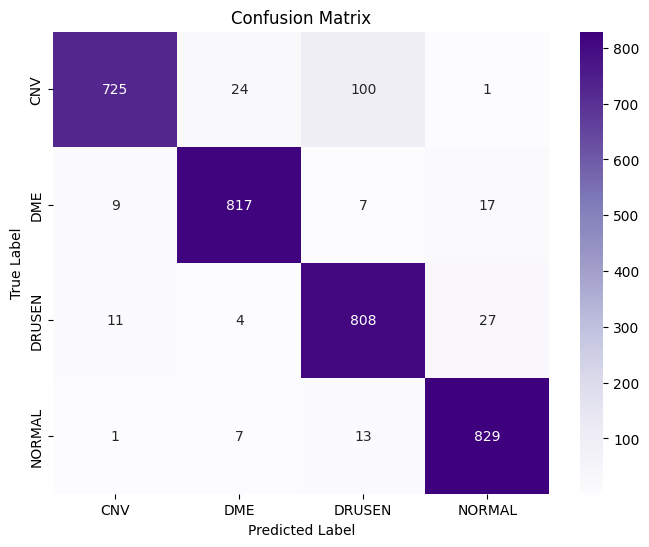

In [42]:
plot_confusion_matrix(true_labels, predicted_labels)